In [2]:
import tensorflow as tf
import librosa
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load style and content

In [3]:
CONTENT_FILENAME = "inputs/p225_166.wav"
STYLE_FILENAME = "inputs/p226_166.wav"
TEST_FILENAME = "inputs/p225_150.wav"

In [4]:
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))
display(Audio(TEST_FILENAME))

In [5]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430])) 
    return S, fs

In [6]:
a_content, fs = read_audio_spectum(CONTENT_FILENAME)
print a_content.shape
print fs
a_style, fs = read_audio_spectum(STYLE_FILENAME)
print a_style.shape
print fs
a_test, fs = read_audio_spectum(TEST_FILENAME)
print a_test.shape
print fs
N_SAMPLES = 230
N_CHANNELS = a_content.shape[0]
a_style = a_style[:N_CHANNELS, :N_SAMPLES]
a_content = a_style[:N_CHANNELS, :N_SAMPLES]
a_test = a_style[:N_CHANNELS, :N_SAMPLES]
print a_style

(1025, 236)
22050
(1025, 273)
22050
(1025, 230)
22050
[[  1.47916925e+00   7.13851035e-01   5.30565262e-01 ...,   9.00608063e-01
    2.67268389e-01   9.37023759e-02]
 [  1.93329477e+00   1.87911272e+00   1.82209897e+00 ...,   1.36148083e+00
    9.19342220e-01   5.56892097e-01]
 [  1.80064845e+00   1.84000897e+00   1.68241417e+00 ...,   1.54671812e+00
    1.17596090e+00   4.87270772e-01]
 ..., 
 [  6.84709940e-03   3.42618395e-03   1.38719570e-05 ...,   5.98537226e-05
    5.63245048e-05   2.42068800e-05]
 [  6.84981095e-03   3.43691371e-03   1.31288762e-05 ...,   1.10720712e-05
    5.41508343e-05   4.27790874e-05]
 [  6.84737554e-03   3.42261977e-03   3.91162666e-06 ...,   1.45466447e-05
    5.45602124e-05   4.81361712e-05]]


### Visualize spectrograms for content and style tracks

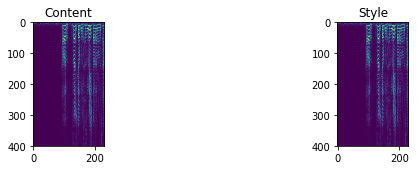

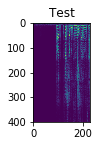

In [11]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(2, 2, 2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.show()
plt.subplot(2, 2, 3)
plt.title('Test')
plt.imshow(a_test[:400,:])
plt.show()

### Compute content and style feats

In [8]:
N_FILTERS = 4096

a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:])
a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])

print a_content_tf

# filter shape is "[filter_height, filter_width, in_channels, out_channels]"
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11))
kernel = np.random.randn(1, 11, N_CHANNELS, N_FILTERS)*std
    
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    # data shape is "[batch, in_height, in_width, in_channels]",
    x = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    net = tf.nn.relu(conv)

    content_features = net.eval(feed_dict={x: a_content_tf})
    style_features = net.eval(feed_dict={x: a_style_tf})
    
    features = np.reshape(style_features, (-1, N_FILTERS))
    style_gram = np.matmul(features.T, features) / N_SAMPLES

[[[[  1.47916925e+00   1.93329477e+00   1.80064845e+00 ...,
      6.84709940e-03   6.84981095e-03   6.84737554e-03]
   [  7.13851035e-01   1.87911272e+00   1.84000897e+00 ...,
      3.42618395e-03   3.43691371e-03   3.42261977e-03]
   [  5.30565262e-01   1.82209897e+00   1.68241417e+00 ...,
      1.38719570e-05   1.31288762e-05   3.91162666e-06]
   ..., 
   [  9.00608063e-01   1.36148083e+00   1.54671812e+00 ...,
      5.98537226e-05   1.10720712e-05   1.45466447e-05]
   [  2.67268389e-01   9.19342220e-01   1.17596090e+00 ...,
      5.63245048e-05   5.41508343e-05   5.45602124e-05]
   [  9.37023759e-02   5.56892097e-01   4.87270772e-01 ...,
      2.42068800e-05   4.27790874e-05   4.81361712e-05]]]]


### Optimize

In [9]:
from sys import stderr

ALPHA= 1e-2
learning_rate= 1e-2
iterations = 100

result = None
with tf.Graph().as_default():

    # Build graph with variable input
#     x = tf.Variable(np.zeros([1,1,N_SAMPLES,N_CHANNELS], dtype=np.float32), name="x")
    x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    
    net = tf.nn.relu(conv)

    content_loss = ALPHA * 2 * tf.nn.l2_loss(
            net - content_features)

    style_loss = 0

    _, height, width, number = map(lambda i: i.value, net.get_shape())

    size = height * width * number
    feats = tf.reshape(net, (-1, number))
    gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES
    style_loss = 2 * tf.nn.l2_loss(gram - style_gram)

     # Overall loss
    loss = content_loss + style_loss

    opt = tf.contrib.opt.ScipyOptimizerInterface(
          loss, method='L-BFGS-B', options={'maxiter': 10000})
        
    # Optimization
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
       
        print('Started optimization.')
        opt.minimize(sess)
    
        print 'Final loss:', loss.eval()
        result = x.eval()

Started optimization.
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  Objective function value: 0.000093
  Number of iterations: 1250
  Number of functions evaluations: 1303
Final loss: 9.32517e-05


In [54]:
print result.shape
a = np.zeros_like(a_test)
a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = 'outputs/out.wav'
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)

ValueError: could not broadcast input array from shape (1025,236) into shape (1025,230)

In [10]:
print OUTPUT_FILENAME
display(Audio(OUTPUT_FILENAME))

NameError: name 'OUTPUT_FILENAME' is not defined

### Visualize spectrograms

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1,3,2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.subplot(1,3,3)
plt.title('Result')
plt.imshow(a[:400,:])
plt.show()

### Invert spectrogram and save the result